In [24]:
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import DMatrix
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pyfolio

from datalayer import get_train_data
from plot_curves import plot_learning_curve


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data analysis

In [25]:
data = get_train_data()

data.head()

/Users/helderrezende/coding_challenge_pred_ibov/datalayer.py:38: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  result = result.resample(resample_time).agg({'close': 'last'})


,ibov,spx,uc1,br_econ_uncert
ref_date,,,,
2000-02-18,0.016882,-0.015530,-0.014888,-0.244322
2000-03-09,0.003007,0.103190,-0.005703,0.000000
2000-03-29,-0.192073,-0.070497,0.021508,0.784052
2000-04-18,0.027146,0.022256,0.019652,0.000000
2000-05-08,-0.067831,-0.035676,0.018722,0.000000


**Correlation**

In [26]:
data.corr()

,ibov,spx,uc1,br_econ_uncert
ibov,1.000000,0.572297,-0.543317,-0.029350
spx,0.572297,1.000000,-0.396351,-0.134966
uc1,-0.543317,-0.396351,1.000000,0.123112
br_econ_uncert,-0.029350,-0.134966,0.123112,1.000000


### Ibov analysis

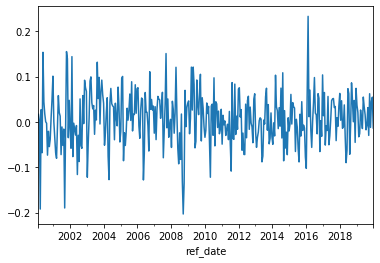

In [27]:
data['ibov'].plot()

#### Looking autocorrelation

##### Autocorrelation

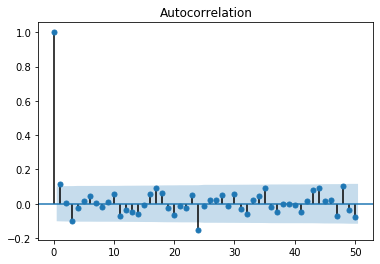

In [28]:
plot_acf(data['ibov'].values, lags=50);

##### Partial autocorrelation

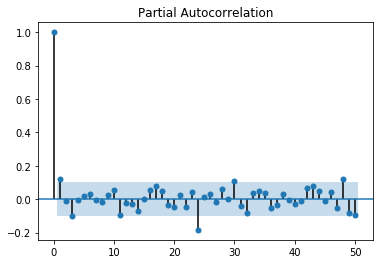

In [29]:
plot_pacf(data['ibov'].values, lags=50);

### Features

#### Creating lags

In [30]:
data['ibov_lag1'] = data['ibov'].shift(1)

data['ibov_lag3'] = data['ibov'].shift(3)

data['spx_lag1'] = data['spx'].shift(1)
data['uc1_lag1'] = data['uc1'].shift(1)
data['br_econ_uncert_lag1'] = data['br_econ_uncert'].shift(1)

data = data.drop(columns=['spx', 'uc1', 'br_econ_uncert'])

data = data.dropna()

In [31]:
data.head()

,ibov,ibov_lag1,ibov_lag3,spx_lag1,uc1_lag1,br_econ_uncert_lag1
ref_date,,,,,,
2000-04-18,0.027146,-0.192073,0.016882,-0.070497,0.021508,0.784052
2000-05-08,-0.067831,0.027146,0.003007,0.022256,0.019652,0.000000
2000-05-26,0.153711,-0.067831,-0.192073,-0.035676,0.018722,0.000000
2000-06-15,0.044142,0.153711,0.027146,0.064436,-0.017027,1.580763
2000-07-05,0.017406,0.044142,-0.067831,-0.000680,0.006324,-0.437437


#### Creating date features

In [32]:
data['month'] = data.reset_index()['ref_date'].dt.month.values

In [33]:
data.head()

,ibov,ibov_lag1,ibov_lag3,spx_lag1,uc1_lag1,br_econ_uncert_lag1,month
ref_date,,,,,,,
2000-04-18,0.027146,-0.192073,0.016882,-0.070497,0.021508,0.784052,4
2000-05-08,-0.067831,0.027146,0.003007,0.022256,0.019652,0.000000,5
2000-05-26,0.153711,-0.067831,-0.192073,-0.035676,0.018722,0.000000,5
2000-06-15,0.044142,0.153711,0.027146,0.064436,-0.017027,1.580763,6
2000-07-05,0.017406,0.044142,-0.067831,-0.000680,0.006324,-0.437437,7


### Model

In [34]:
X = data.drop('ibov', axis=1).values 
y = data['ibov'].values

#### Perfomance 

In [35]:
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

In [36]:
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

MAE: -0.049 (0.005)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

#### Tunning Parameters

Source: https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur/

In [ ]:
params = {'min_child_weight': [1, 3, 5, 7],
         'gamma': [i/10.0 for i in range(5 ,11)],
         'subsample': [i/10.0 for i in range(6, 11)],
         'colsample_bytree': [i/10.0 for i in range(6, 11)],
         'max_depth': [3, 5, 7, 9, 12]}

kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(model, params, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#### Learning Curve

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model no training data
model = XGBRegressor(objective='reg:squarederror')
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.450707	validation_1-rmse:0.439456
[1]	validation_0-rmse:0.40662	validation_1-rmse:0.395315
[2]	validation_0-rmse:0.367011	validation_1-rmse:0.35565
[3]	validation_0-rmse:0.331442	validation_1-rmse:0.320021
[4]	validation_0-rmse:0.299521	validation_1-rmse:0.288038
[5]	validation_0-rmse:0.270895	validation_1-rmse:0.259348
[6]	validation_0-rmse:0.245246	validation_1-rmse:0.233635
[7]	validation_0-rmse:0.22229	validation_1-rmse:0.210615
[8]	validation_0-rmse:0.201771	validation_1-rmse:0.190034
[9]	validation_0-rmse:0.183458	validation_1-rmse:0.171789
[10]	validation_0-rmse:0.167139	validation_1-rmse:0.155424
[11]	validation_0-rmse:0.152552	validation_1-rmse:0.141143
[12]	validation_0-rmse:0.139585	validation_1-rmse:0.12859
[13]	validation_0-rmse:0.127989	validation_1-rmse:0.117395
[14]	validation_0-rmse:0.117524	validation_1-rmse:0.107633
[15]	validation_0-rmse:0.108463	validation_1-rmse:0.099162
[16]	validation_0-rmse:0.100403	validation_1-rmse:0.091666
[17]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
plot_learning_curve(model)

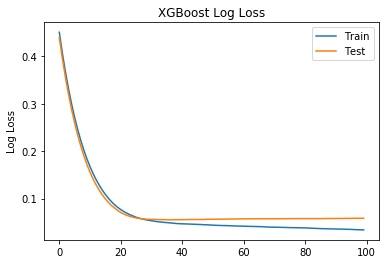

In [19]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

using early_stopping_rounds 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model no training data
model = XGBRegressor(objective='reg:squarederror')
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=5, eval_metric=["rmse"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.450707	validation_1-rmse:0.439456
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.40662	validation_1-rmse:0.395315
[2]	validation_0-rmse:0.367011	validation_1-rmse:0.35565
[3]	validation_0-rmse:0.331442	validation_1-rmse:0.320021
[4]	validation_0-rmse:0.299521	validation_1-rmse:0.288038
[5]	validation_0-rmse:0.270895	validation_1-rmse:0.259348
[6]	validation_0-rmse:0.245246	validation_1-rmse:0.233635
[7]	validation_0-rmse:0.22229	validation_1-rmse:0.210615
[8]	validation_0-rmse:0.201771	validation_1-rmse:0.190034
[9]	validation_0-rmse:0.183458	validation_1-rmse:0.171789
[10]	validation_0-rmse:0.167139	validation_1-rmse:0.155424
[11]	validation_0-rmse:0.152552	validation_1-rmse:0.141143
[12]	validation_0-rmse:0.139585	validation_1-rmse:0.12859
[13]	validation_0-rmse:0.127989	validation_1-rmse:0.117395
[14]	validation_0-rmse:0.11752

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
plot_learning_curve(model)

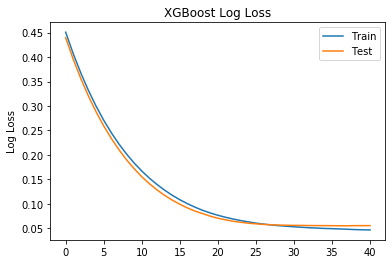

In [17]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()